<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic_csv = '../../DATA/titanic_train.csv'
df=pd.read_csv(titanic_csv, index_col='PassengerId')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
df.dtypes


Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [5]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
163,0,3,"Bengtsson, Mr. John Viktor",male,26.0,0,0,347068,7.7750,NaN,S
95,0,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,NaN,S
416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,NaN,S
517,1,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S


In [6]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Number male missing 124
Number female missing 53


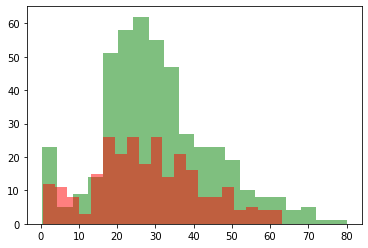

In [7]:
# Check out Age
plt.hist(df[df['Sex']=='male']['Age'], bins=20, color="green", alpha=0.5)
plt.hist(df[df['Sex']=='female']['Age'], bins=20, color="red", alpha=0.5)
print("Number male missing", df[df['Sex']=='male']['Age'].isna().sum())
print("Number female missing", df[df['Sex']=='female']['Age'].isna().sum())

In [8]:
# ANSWER
print(df.groupby("Survived").mean())

            Pclass        Age     SibSp     Parch       Fare
Survived                                                    
0         2.531876  30.626179  0.553734  0.329690  22.117887
1         1.950292  28.343690  0.473684  0.464912  48.395408


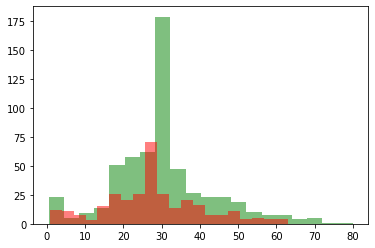

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
(714, 11)


In [9]:
#print(df.groupby("Sex")["Age"].transform("median"))
df["Age_imp"] = df["Age"].fillna(df.groupby("Sex")["Age"].transform("median"))
plt.hist(df[df['Sex']=='male']['Age_imp'], bins=20, color="green", alpha=0.5)
plt.hist(df[df['Sex']=='female']['Age_imp'], bins=20, color="red", alpha=0.5)
# looking at chart, would probably skew resuls, so let's not use
df.drop("Age_imp", axis=1, inplace=True)
df.dropna(subset=['Age'], inplace=True)
plt.show()
print(df.dtypes)
print(df.shape)

In [10]:
df.Embarked.value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [11]:
# ANSWER
feature_cols = ['Pclass', 'Parch']

X = df[feature_cols]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [12]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [13]:
# ANSWER
# Create Model
logreg = LogisticRegression(solver='liblinear',max_iter=100)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [14]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [15]:
# ANSWER
print(logreg.coef_)
# with radnom_state =1 is [[-0.86727899  0.26584821]]

[[-0.89066594  0.28962348]]


The computed intercept (`intercept_`) is the 1st element of another array:

In [16]:
# ANSWER
print(logreg.intercept_)
# with random_state = 1, is [1.5219749]

[1.46037943]


We can create tuples of the predictor names and coefficients like this:

In [17]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Pclass', -0.8906659410685767), ('Parch', 0.28962347591376825)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [18]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.890666
Parch       +0.289623


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [19]:
# ANSWER
#
res = (logreg.predict_proba(X_train)[:,1] > .5) + y_train
#print(res)
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_train.count())

accuracy_score = correct / y_train.count()
print("TRAIN DATA: Accuracy score = ", accuracy_score)


Correct predictions  373  out of  535
TRAIN DATA: Accuracy score =  0.697196261682243


What is the  `accuracy_score` for the test data?

In [20]:
# ANSWER
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
#print(res)
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)


Correct predictions  117  out of  179
TEST DATA: Accuracy score =  0.6536312849162011


What can we say aout this result?

ANSWER
- Our regression is giving a slightly better result than on test data
- Would want to try again using different sets of test/train

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [21]:
# ANSWER

In [22]:
# Build Model
feature_cols = ['Pclass', 'Parch', 'Age']

X = df[feature_cols]
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)

# Score
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)

Correct predictions  135  out of  179
TEST DATA: Accuracy score =  0.7541899441340782


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [23]:
# ANSWER
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[99 13]
 [31 36]]


Nb. Here is how `confusion_matrix` arranges its output:

In [24]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

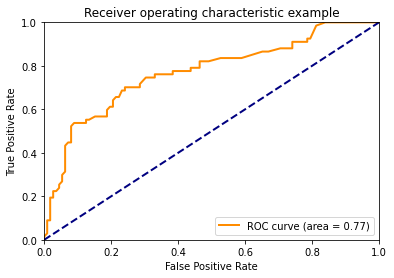

In [25]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [26]:
metrics.confusion_matrix(y_test, logreg.predict(X_test))

array([[99, 13],
       [31, 36]], dtype=int64)

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [27]:
# Reload our data again
df=pd.read_csv(titanic_csv, index_col='PassengerId')

titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.sample(10)

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
272,1,"Tornquist, Mr. William Henry",25.0,0,0,LINE,0.0000,NaN,0,1,0,0,1,0,0,1
543,0,"Andersson, Miss. Sigrid Elisabeth",11.0,4,2,347082,31.2750,NaN,1,0,0,0,1,0,0,1
708,1,"Calderhead, Mr. Edward Pennington",42.0,0,0,PC 17476,26.2875,E24,0,1,0,0,1,1,0,0
236,0,"Harknett, Miss. Alice Phoebe",NaN,0,0,W./C. 6609,7.5500,NaN,1,0,0,0,1,0,0,1
731,1,"Allen, Miss. Elisabeth Walton",29.0,0,0,24160,211.3375,B5,1,0,0,0,1,1,0,0
487,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",35.0,1,0,19943,90.0000,C93,1,0,0,0,1,1,0,0
712,0,"Klaber, Mr. Herman",NaN,0,0,113028,26.5500,C124,0,1,0,0,1,1,0,0
670,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",NaN,1,0,19996,52.0000,C126,1,0,0,0,1,1,0,0
610,1,"Shutes, Miss. Elizabeth W",40.0,0,0,PC 17582,153.4625,C125,1,0,0,0,1,1,0,0


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [28]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))
titanic_with_dummies.sample(10)

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
772,0,"Jensen, Mr. Niels Peder",48.000000,0,0,350047,7.8542,NaN,0,1,0,0,1,0,0,1
885,0,"Sutehall, Mr. Henry Jr",25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,0,1,0,0,1,0,0,1
698,1,"Mullens, Miss. Katherine ""Katie""",24.018519,0,0,35852,7.7333,NaN,1,0,0,1,0,0,0,1
644,1,"Foo, Mr. Choong",28.816667,0,0,1601,56.4958,NaN,0,1,0,0,1,0,0,1
792,0,"Gaskell, Mr. Alfred",16.000000,0,0,239865,26.0000,NaN,0,1,0,0,1,0,1,0
58,0,"Novel, Mr. Mansouer",28.500000,0,0,2697,7.2292,NaN,0,1,1,0,0,0,0,1
704,0,"Gallagher, Mr. Martin",25.000000,0,0,36864,7.7417,NaN,0,1,0,1,0,0,0,1
413,1,"Minahan, Miss. Daisy E",33.000000,1,0,19928,90.0000,C78,1,0,0,1,0,1,0,0
275,1,"Healy, Miss. Hanora ""Nora""",24.018519,0,0,370375,7.7500,NaN,1,0,0,1,0,0,0,1


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [29]:
# ANSWER
# Set Feature Both Numerical, Categorical
# Build Model
feature_cols = ["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)
print("Accuracy score ", logreg.score(X_test, y_test))

# Score
#res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
res = logreg.predict(X_test) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)


Accuracy score  0.7982062780269058
Correct predictions  178  out of  223
TEST DATA: Accuracy score =  0.7982062780269058


Plot the ROC curve for the new model:

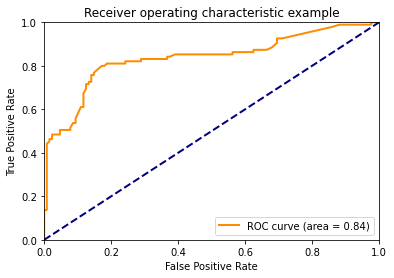

In [30]:
# ANSWER
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [31]:
titanic_with_dummies.dtypes

Survived        int64
Name           object
Age           float64
SibSp           int64
Parch           int64
Ticket         object
Fare          float64
Cabin          object
Sex_female      uint8
Sex_male        uint8
Embarked_C      uint8
Embarked_Q      uint8
Embarked_S      uint8
Pclass_1        uint8
Pclass_2        uint8
Pclass_3        uint8
dtype: object

Can we improve the model by including the remaining features?

In [32]:
# ANSWER
# Build Model
feature_cols = ["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2", "SibSp"]

X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
logreg = LogisticRegression(solver='liblinear',max_iter=100)

# Fit Model
logreg.fit(X_train, y_train)
print("Accuracy score ", logreg.score(X_test, y_test))

# Score
res = (logreg.predict_proba(X_test)[:,1] > .5) + y_test
correct = res[res == 2].count() + res[res == 0].count()
print("Correct predictions ", correct, " out of ", y_test.count())

accuracy_score = correct / y_test.count()
print("TEST DATA: Accuracy score = ", accuracy_score)

Accuracy score  0.8071748878923767
Correct predictions  180  out of  223
TEST DATA: Accuracy score =  0.8071748878923767


In [33]:
# Very marginal improvement adding remaining numerical features

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

Correlation:
          Score     AUROC
Score  1.000000  0.127222
AUROC  0.127222  1.000000
             Score        AUROC
count  5000.000000  5000.000000
mean      0.605041     0.546083
std       0.028302     0.036583
min       0.479821     0.414461
25%       0.587444     0.521684
50%       0.605381     0.546776
75%       0.623318     0.571136
max       0.704036     0.679099


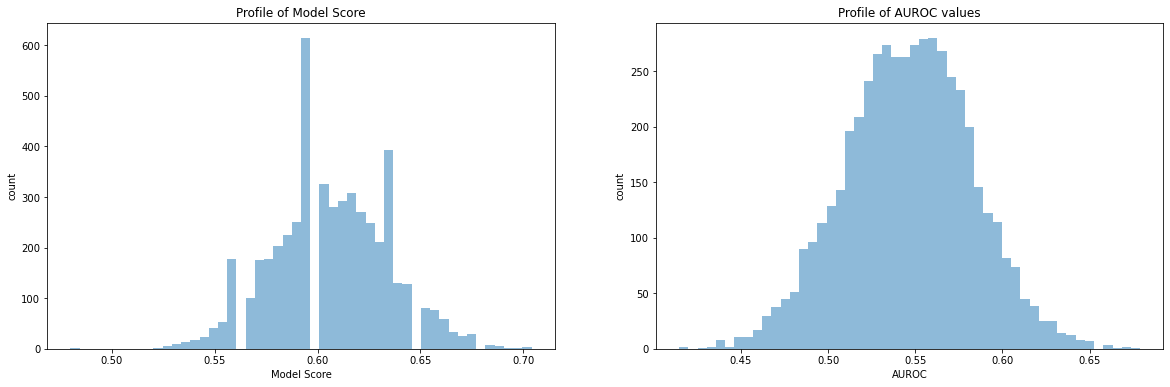

In [34]:
#
# Lets try using a number of different picks of the data
#
# Use a function to do this

feature_cols = ["Age", "Parch"]
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies['Survived']

def RunLogReg(X, y, runs):
    res = []
    for i in range(runs):
        # Make selection fort this run and prepare model
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        logreg = LogisticRegression(solver='liblinear',max_iter=100)

        # Fit Model
        logreg.fit(X_train, y_train)
        
        # Find out predictions from the test data
        preds = logreg.predict_proba(X_test)[:,1]

        # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
        fpr, tpr, _ = metrics.roc_curve(y_test, preds)

        # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
        roc_auc = metrics.auc(fpr, tpr)

        res.append([logreg.score(X_test, y_test), roc_auc])
    return res

# Convert into a data frame and give columns a name
# Do a large number of runs
r = pd.DataFrame(RunLogReg(X, y, 5000))
r.columns = ['Score', 'AUROC']

# Some information about the series of results
print("Correlation:")
print(r.corr())
print(r.describe())

# Lets see what they look like
plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.xlabel('Model Score')
plt.ylabel('count')
plt.title('Profile of Model Score')
plt.hist(r["Score"], bins=50, alpha=0.5)
plt.subplot(1, 2, 2)
plt.xlabel('AUROC')
plt.ylabel('count')
plt.title('Profile of AUROC values')
plt.hist(r["AUROC"], bins=50, alpha=0.5, label="AUROC")
plt.show()




---



---



> > > > > > > > > © 2019 Institute of Data


---



---



